# Environment and Simulation Setup
## Creating and Sourcing Models

This tasks includes the meshes (`.stl` files), collision geometry, and `.urdf` files for each object. We plan to use the Franka panda robotic arm, which is the same arm purchased in our research group (the Computational Robotics Lab at Harvard).

In [ ]:
import os
import pydot

from pydrake.geometry import StartMeshcat
from pydrake.systems.analysis import Simulator
from IPython.display import HTML, SVG, display
from pydrake.visualization import ModelVisualizer
from pydrake.all import Simulator, StartMeshcat, DiagramBuilder, MeshcatVisualizer, namedview

from manipulation import running_as_notebook
from manipulation.station import MakeHardwareStation, load_scenario

### Jenga Blocks and Table

In [ ]:
meshcat = StartMeshcat()

In [ ]:
def make_stack():
    output = ''
    num_layers = 18 # actual number is 18, but use a smaller number to speed up sim setup
    num_blocks_per_layer = 3
    block_width = 0.025
    block_height = 0.015
    for i in range(num_layers):
        # alternate block orientations
        layer_in_x_direction = i % 2 == 0
        for j in range(num_blocks_per_layer):
            x = (block_width * (j - 1)) if layer_in_x_direction else 0
            y = 0 if layer_in_x_direction else (block_width * (j - 1))
            z = block_height * (i + 0.5)
            orientation = "{ deg: [0, 0, 0] }" if layer_in_x_direction else "{ deg: [0, 0, 90] }"
            output += f"""
- add_model:
    name: block_{i * 3 + j}
    file: package://jengabot/models/jenga_block.sdf
    default_free_body_pose:
        jenga_block_link:
            translation: [{x}, {y}, {z}]
            rotation: !Rpy {orientation}"""
    return output

print(make_stack())

In [ ]:
def create_scene():
    scenario_data = """
directives:
- add_model:
    name: table_top
    file: package://jengabot/models/table_top.sdf
- add_weld:
    parent: world
    child: table_top::table_top_link
"""

    camera_data = """
    - add_frame:
        name: camera0_origin
        X_PF:
            base_frame: world
            rotation: !Rpy { deg: [0, 0, 0]}
            translation: [0, 1, 1]
    cameras:
        camera0:
        name: camera0
        depth: True
        X_PB:
            base_frame: camera0_origin
    """

    scenario_data += make_stack()
    # scenario_data += camera_data
    print(scenario_data)
    
    scenario = load_scenario(data=scenario_data)
    station = DiagramBuilder()
    
    station = MakeHardwareStation(scenario, meshcat, package_xmls=['./package.xml'])
    #station = builder.AddSystem(MakeHardwareStation(scenario, meshcat, package_xmls=['./package.xml']))
    #context = station.CreateDefaultContext()


    simulator = Simulator(station)

    
    
    meshcat.StartRecording()
    simulator.AdvanceTo(2.0 if running_as_notebook else 0.1)
    meshcat.PublishRecording()


create_scene()

### Load Robot Model

In [ ]:
meshcat.Delete()
meshcat = StartMeshcat()



In [ ]:
scenario_data = """
directives:
- add_directives:
    file: package://manipulation/clutter.dmd.yaml
model_drivers:
    iiwa: !IiwaDriver
      hand_model_name: wsg
    wsg: !SchunkWsgDriver {}
"""
scenario = load_scenario(data=scenario_data)
station = MakeHardwareStation(scenario, meshcat=meshcat)
context = station.CreateDefaultContext()

station.GetInputPort("wsg.position").FixValue(context, [0.1])
station.ForcedPublish(context)

In [ ]:
# initialize context
station_context = station.CreateDefaultContext()
plant = station.GetSubsystemByName("plant")
plant_context = plant.GetMyContextFromRoot(station_context)

In [ ]:
display(
    SVG(
        pydot.graph_from_dot_data(station.GetGraphvizString(max_depth=1))[
            0
        ].create_svg()
    )
)

In [ ]:
# provide initial states
import numpy as np
q0 = np.array([-1.57, 0.1, 0, -1.2, 0, 1.6, 0])
iiwa = plant.GetModelInstanceByName("iiwa")
# set the joint positions of the kuka arm
plant.SetPositions(plant_context, iiwa, q0)
# examine the output port
station.GetOutputPort("iiwa.position_measured").Eval(station_context)

In [ ]:
IiwaPositionView = namedview(
    "IiwaPositions",
    plant.GetPositionNames(iiwa, always_add_suffix=False),
)
q0 = IiwaPositionView.Zero()
q0.iiwa_joint_1 = -1.57
q0.iiwa_joint_2 = 0.1
q0.iiwa_joint_4 = -1.2
q0.iiwa_joint_6 = 1.6
print(q0)
plant.SetPositions(plant_context, iiwa, q0[:])

## Camera Setup

In [77]:
import mpld3
import numpy as np
import pydot
from IPython.display import SVG, display
from matplotlib import pyplot as plt
from pydrake.all import DiagramBuilder, StartMeshcat

from manipulation import FindResource, running_as_notebook
from manipulation.scenarios import AddMultibodyTriad
from manipulation.station import (
    AddPointClouds,
    MakeHardwareStation,
    load_scenario,
)

In [78]:
# Start the visualizer.
meshcat.Delete()
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [79]:

scenario_data = """
directives:
- add_model:
    name: table_top
    file: package://jengabot/models/table_top.sdf
- add_weld:
    parent: world
    child: table_top::table_top_link
"""
scenario_data += make_stack()


scenario_data += """
- add_model:
    name: camera
    file: package://manipulation/camera_box.sdf
- add_weld:
    parent: world
    child: camera::base
    X_PC:
        translation: [0.5, 0.1, 0.2]
        # Point slightly down towards camera
        # RollPitchYaw(0, -0.2, 0.2) @ RollPitchYaw(-np.pi/2, 0, np.pi/2)
        rotation: !Rpy { deg: [-100, 0, 100] }
cameras:
    main_camera:
        name: camera0
        depth: True
        X_PB:
            base_frame: camera::base
"""

In [83]:


def DepthCameraDemoSystem():
    builder = DiagramBuilder()

    scenario = load_scenario(data=scenario_data)
    #station = builder.AddSystem(MakeHardwareStation(scenario, meshcat))
    station = builder.AddSystem(MakeHardwareStation(scenario, meshcat, package_xmls=['./package.xml']))

    # Export the camera outputs
    builder.ExportOutput(
        station.GetOutputPort("camera0.rgb_image"), "rgb_image"
    )
    builder.ExportOutput(
        station.GetOutputPort("camera0.depth_image"), "depth_image"
    )

    to_point_cloud = AddPointClouds(
        scenario=scenario, station=station, builder=builder, meshcat=meshcat
    )

    # Add a box for the camera in the environment.
    plant = station.GetSubsystemByName("plant")
    camera_instance = plant.GetModelInstanceByName("camera")
    scene_graph = station.GetSubsystemByName("scene_graph")
    AddMultibodyTriad(
        plant.GetFrameByName("base", camera_instance),
        scene_graph,
        length=0.1,
        radius=0.005,
    )

    # Export the point cloud output.
    builder.ExportOutput(
        to_point_cloud["camera0"].point_cloud_output_port(), "point_cloud"
    )

    diagram = builder.Build()
    #station = MakeHardwareStation(scenario, meshcat, package_xmls=['./package.xml'])
    
    diagram.set_name("depth_camera_demo_system")
    return diagram

In [91]:


def plot_camera_images():
    system = DepthCameraDemoSystem()

    # Evaluate the camera output ports to get the images.
    context = system.CreateDefaultContext()
    system.ForcedPublish(context)
    color_image = system.GetOutputPort("rgb_image").Eval(context)
    depth_image = system.GetOutputPort("depth_image").Eval(context)

    # Plot the two images.
    plt.subplot(121)
    plt.imshow(color_image.data)
    plt.title("Color image")
    plt.subplot(122)
    plt.imshow(np.squeeze(depth_image.data))
    plt.title("Depth image")
    # mpld3.display()
    plt.show()


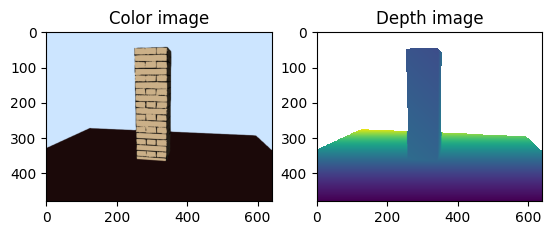

In [92]:

plot_camera_images()

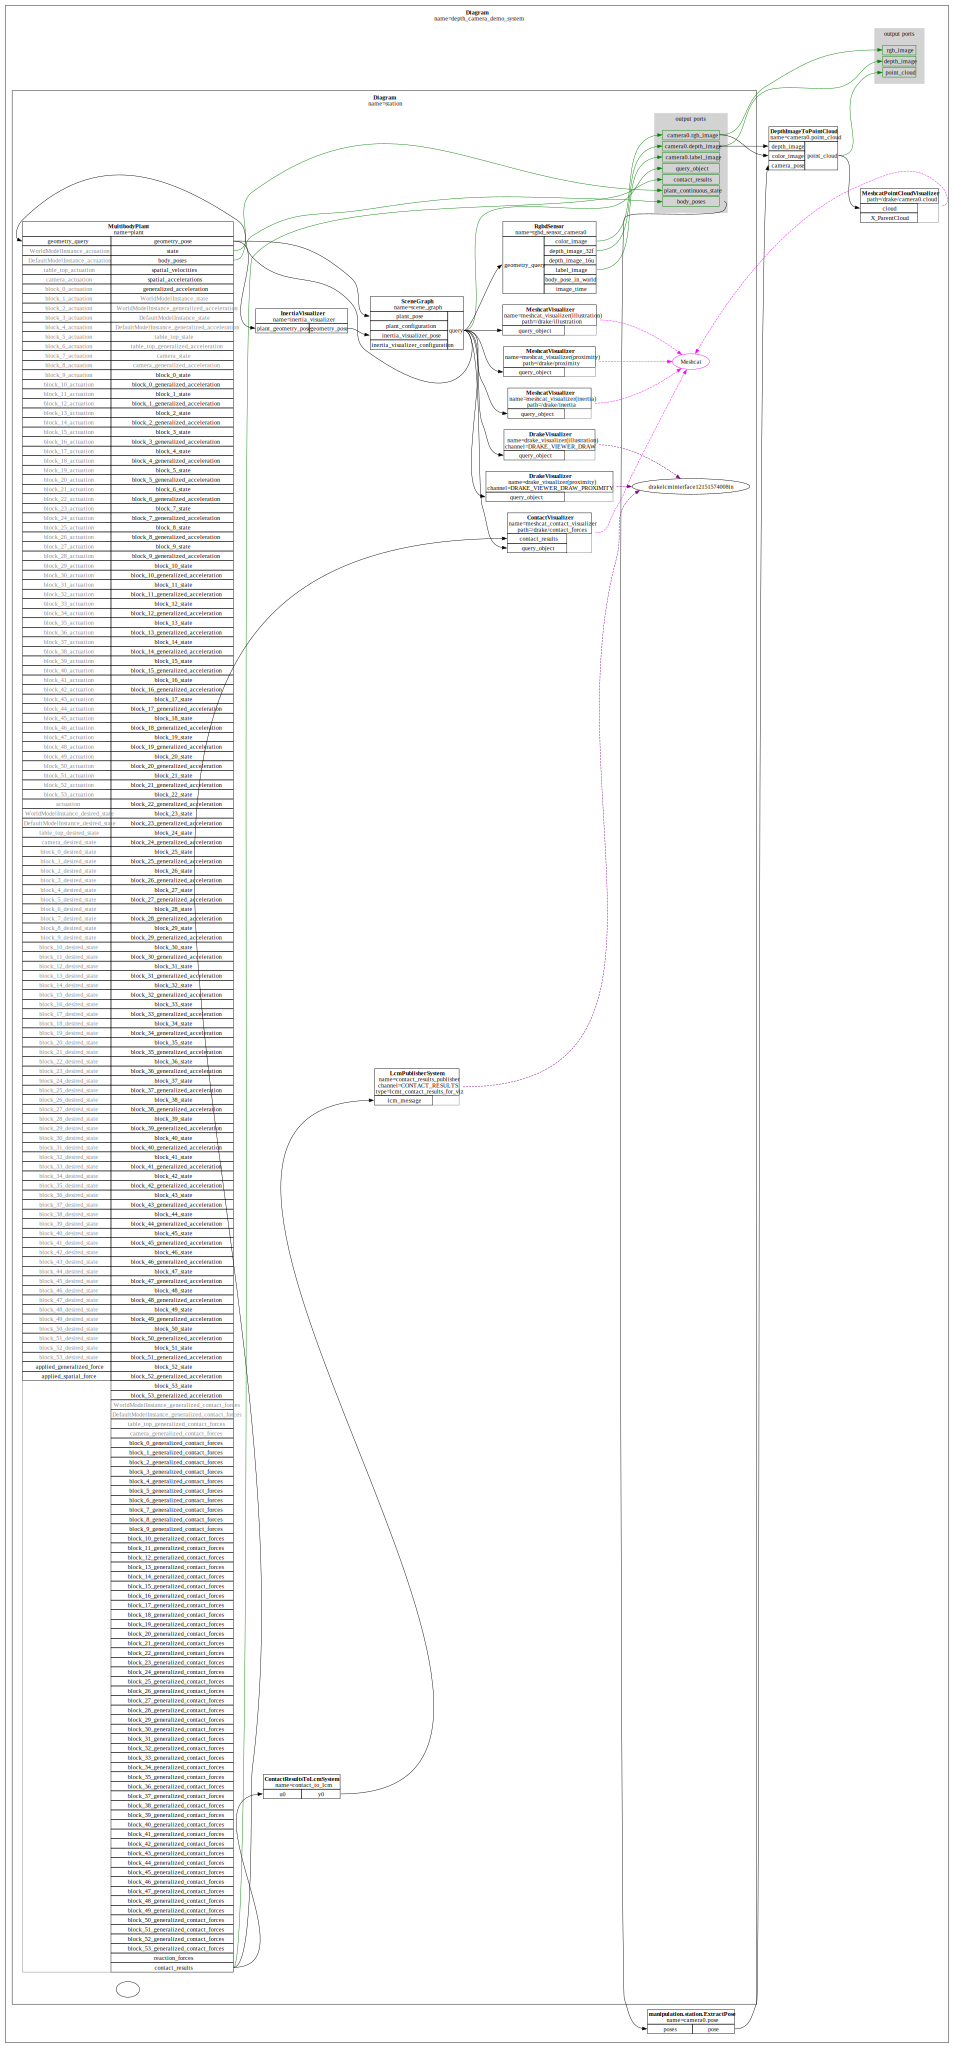

: 

In [94]:
def draw_diagram():
    system = DepthCameraDemoSystem()
    display(
        SVG(
            pydot.graph_from_dot_data(system.GetGraphvizString(max_depth=2))[
                0
            ].create_svg()
        )
    )


draw_diagram()